# Set things up, import some libraries.
We used music21, keras and musescore 2 for visualisation

In [45]:
# TF_CPP_MIN_LOG_LEVEL=2
import music21 
from music21 import *
from music21 import corpus # easy/fast import of preprocessed songs

import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from scipy.stats import entropy
import random
import os
import datetime
from datetime import *

import tensorflow
import keras
from keras.models import Model
from keras.layers import Dense, Lambda, Input, Conv1D
from keras.layers import Dropout, Activation, concatenate
from keras.layers import LSTM, TimeDistributed

from tqdm import * # optional import, makes nice progress bars for loops

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

from IPython.core.display import display, HTML

In [38]:
# from tensorflow.python.client import device_lib

# def get_available_gpus():
#     local_device_protos = device_lib.list_local_devices()
#     return [x.name for x in local_device_protos if x.device_type == 'GPU']



In [3]:
# also install 'musescore 2' somewhere on your computer to visualize chords
# if it complains about a missing XML path, the following works
# linux:
# environment.set("musescoreDirectPNGPath", "/usr/bin/musescore")
# environment.set("musicxmlPath", "/usr/bin/musescore")
# windows:
# environment.set("musescoreDirectPNGPath",     "C:/Program Files (x86)/MuseScore 2/bin/MuseScore.exe")
# environment.set("musicxmlPath", "C:/Program Files (x86)/MuseScore 2/bin/MuseScore.exe")

https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

In [4]:
# a few debugging functions

In [5]:
def printChord(c):
    print(f'{[x.nameWithOctave for x in c.pitches]} ({c.pitchedCommonName}), Root:{c.root()}, int:{c.intervalVector}, normalOrder:{c.normalOrder}')
    c.show()
    
def printNote(f):
    if f.name == 'rest':
        st = f'{f.name}'
    else:
        st = f'{f.name} {f.step} {f.octave} {f.pitch.french} {f.pitch} {f.pitch.frequency:0.2f}'
        if f.pitch.accidental:
            st = st +f' {f.pitch.accidental.name}-extra semi-tones:{f.pitch.accidental.alter}'
#     print(st)
    f.addLyric(st)
    return f.show()

def printPitch(p):
    print(f'{p} {p.nameWithOctave} {p.french} {p.octave} {p.frequency}')
    if p.accidental:
        print(f'{p.accidental} {p.accidental.name}-extra semi-tones:{p.accidental.alter}')

In [6]:
n_vocab = 128     # how many notes we encode
n_duration = 16   # how many discrete durations
n_extrastuff = 3  # extra features
lookback = 64     # how far back in time the network looks for predictions
n_total = n_vocab+n_duration+n_extrastuff

In [7]:
def readSong(s, chordify = False, gatherRests=True, qlMult=4, qlMin=1, qlMax=16):
    # chordify toggles putting all parts together
    # gatherRests combines all rests into 1 (no more than 1 contiguous rest)
    
    # qlMult multiplies quarterLengths of notes/rests by that factor
    # qlMin/qlMax restricts note length
    # defaul values mean notes range from "16" (whole) to "1" (a 16th)
    
    notes = []
    
    if chordify == False:
        pp = s.parts
    else:
        pp = [s.chordify()]
        # the chordify works here because the songs we picked have only one instrument
        # for more than one instrument one needs to filter by checking the instrument 
        # of s.parts before chordification
    
    lastwasrest = False
    for p in pp:
        for element in p.recurse().notesAndRests: # get rid of everything that isn't notes/chords/rests
            
            duration = int(element.duration.quarterLength *qlMult)
            duration = min(qlMax,max(qlMin,duration)) # don't want longer than whole or shorter than 16th
            ch = ''
            newchord = np.zeros(n_vocab+n_duration+n_extrastuff)
            
            if isinstance(element, note.Rest):
                nn = 0
                if lastwasrest == True and gatherRests == True:
                    continue # no need for multiple rests in this scenario
                lastwasrest = True
                
            elif isinstance(element, note.Note):
                lastwasrest = False
                nn = int(element.pitch.midi)+0
                newchord[nn] = 1
                
            elif isinstance(element, chord.Chord): #this produces multiple notes in the same chord
                lastwasrest = False
                for pi in element.pitches:
                    newchord[pi.midi] = 1 

            newchord[n_vocab+int(duration)-1] = 1
            
            newchord[n_vocab+n_duration+0] = int(element.getOffsetInHierarchy(s)%8)/8.0
            newchord[n_vocab+n_duration+1] = int(element.getOffsetInHierarchy(s)%32)/32.0
            newchord[n_vocab+n_duration+2] = int(element.getOffsetInHierarchy(s)<32) # this means "is this the start of a song"
            notes.append(newchord)
    
    return np.stack(notes)

In [8]:
def readMidiFolder(folder):
    songs = []
    for f in tqdm(os.listdir(folder)):
        s = converter.parse(folder + '/' + f)
        ss = readSong(s, chordify = True, gatherRests=True, qlMult=4, qlMin=1, qlMax=16)
    songs.append(ss) 
    return songs

    

In [9]:
if os.path.isfile('savedsongs.npy'):
    nn_inout = np.load('savedsongs.npy')
else:
    # composers = ['mozart', 'bach','chopin' ]
    composers = ['bach']
    songs = []
    count = 0
    for c in composers:
        for i in tqdm(corpus.getComposer(c)):
            s = corpus.parse(i)
            ss = readSong(s, chordify = True, gatherRests=True, qlMult=4, qlMin=1, qlMax=16)
            songs.append(ss)

    nn_inout = np.vstack(songs)
    nn_inout.shape
    print(len(songs))
    print(songs[0].shape)
    np.save('savedsongs.npy',nn_inout)

In [10]:

# nn_inout = np.load('bach147.npy')

In [11]:
# Add '0' at the end to make sure it fits blocks of 32/64
# TODO: this concatenates all the songs one after the other, this means that some blocks contain the end 
# of the previous song + the beginning of the next one as if they were connected.

nn_inout2 = np.pad(nn_inout,((0,lookback-nn_inout.shape[0]%lookback),(0,0)), 'constant', constant_values=(0))
nn_inout2 = nn_inout2.reshape(-1, lookback, n_total)
nn_inout2.shape


(678, 64, 147)

In [58]:
# this evaluates the song entropy, median repetition frequency 
# and percentage of chords that are not followed by identical chords

def subsongStats(subsong):
    vs = np.argmax(subsong[:n_vocab], axis=1)
    e = entropy([list(vs).count(x) for x in set(vs)]) # note entropy

    seq = []
    last = vs[0]
    count = 0
    for i in range(len(vs)):
        if last != vs[i]:
            seq.append(count)
            last = vs[i]
            count = 1
        else:
            count = count + 1
    
    seq.append(count)
    m = np.median(seq)
    if (len(seq) == 0):
        print(vs, seq, e, m)
    r = seq.count(1)/len(seq) # how frequent "single notes"(1) is in the different sequence lengths
    r2 = seq.count(1)/len(subsong) # how frequent single notes are in the song
    
    return vs, e, m, r, r2

print(subsongStats(nn_inout2[25]))


(array([57, 54, 50, 57, 57, 50, 54, 54, 55, 50, 50, 43, 43, 45, 47, 48, 48,
       48, 43, 43, 48, 54, 55, 55, 55, 54, 52, 54, 55, 57, 54, 50, 57, 57,
       50, 55, 57, 59, 61, 62, 62, 57, 57, 58, 58, 59, 55, 57, 57, 50, 55,
       54, 52, 50, 48, 47, 48, 50, 52, 52, 54, 56, 57, 57, 57]), 2.3202570162200793, 1.0, 0.7083333333333334, 0.5230769230769231)


In [13]:
# evaluate the values of the initial corpus

plt.figure(figsize=(8,16))
plt.subplot(411)
plt.hist(list(zip(*[subsongStats(nn_inout2[i]) for i in range(nn_inout2.shape[0])]))[1], bins=30)
plt.title('entropy of input song')
plt.subplot(412)
plt.hist(list(zip(*[subsongStats(nn_inout2[i]) for i in range(nn_inout2.shape[0])]))[2], bins=100)
plt.title('median repetition length of source songs')
plt.subplot(413)
plt.hist(list(zip(*[subsongStats(nn_inout2[i]) for i in range(nn_inout2.shape[0])]))[3], bins=30)
plt.title('percentage of non-repeated notes in source songs repetitions');
plt.subplot(414)
plt.hist(list(zip(*[subsongStats(nn_inout2[i]) for i in range(nn_inout2.shape[0])]))[4], bins=30)
plt.title('percentage of non-repeated notes in source songs');



In [53]:
# clean the prediction by zeroing out non-activated values
def cleanpred(pred, threshold=0.8):
    t = np.max(pred[:n_vocab]) * threshold
    du = np.argmax(pred[n_vocab:])
    
    cp = np.zeros(pred.shape)
    cp[np.where(pred[:n_vocab] > t)] = 1
    cp[n_vocab+du] = 1
    cp[n_vocab+n_duration:] = pred[n_vocab+n_duration:] # copy the offsets as is
    return cp

# sorry for the name abuse, it's not a bitfield, just a vector of [0,1]
def predbitfieldtonote(pred, threshold=0.8, colorize=False):
    # colorize helps vizualise the certainty chords were likely to be produced
    
    mm = np.max(pred[:n_vocab])
    t = np.max(pred[:n_vocab])*threshold
    # take the maximum value of the predicted vector as the base so as to generate at least one note
    # except if that note is 0, in which case generate only a rest
    
    du = np.argmax(pred[n_vocab:])
    if np.argmax(pred)==0:
        n = note.Rest()
        n.duration.quarterLength = (du+1)/4
    else:
        nns = []
        for pp in np.where(pred[:n_vocab] > t)[0]:
            nn = note.Note()
            nn.pitch.midi = pp
            if colorize==True:
                if pred[pp] == mm:
                    nn.color = 'black'
                elif pred[pp] > mm*0.95:
                    nn.color = 'blue'
                elif pred[pp] > mm*0.90:
                    nn.color = 'green'
                elif pred[pp] > mm*0.85:
                    nn.color = 'yellow'
                elif pred[pp] > mm*0.8:
                    nn.color = 'red'
                else:
                    nn.color = 'purple'
        
            nns.append(nn)
        n = chord.Chord(nns)
        n.duration.quarterLength = (du+1)/(n_duration/4) # revert the duration back to [4->0.25] range. Needs to be changed to predict shorter note durations
    return n

def predtostream(pred):
    s = stream.Stream()
    for i in range(len(pred)):
        n = predbitfieldtonote(pred[i])
        s.append(n)
    return s


In [43]:
# given a seed, predict all the arrays of [n_vocab+n_duration+n_extra]
def predictOneBitstream(seed, threshold=0.99, length=128, cleanPred =True):
    inp = seed
    for i in range(length):
        p = model.predict(inp[:,-lookback:,:])
        if cleanPred==True:
            p = cleanpred(p[0,-1])
        else:
            p = p[0,-1]
        inp = np.concatenate([inp,p[newaxis,newaxis,:]], axis=1)

    outp = inp[:,lookback:,:] # remove the seed
    return outp

def predictOneStream(seed, threshold=0.99, l=128, cleanPred =True, colorize=False):
    outp = predictOneBitstream(seed, threshold, l, cleanPred)

    v, e, m, p, p2 = subsongStats(outp[0]) 
    print('entropy: {:.3f} median repetition:{:.3f} percentage single notes{:.3f}/{:.3f}'.format(e,m,p,p2))
    
    output_notes = []
    s = stream.Stream()
    for i in range(len(outp[0])):
        n = predbitfieldtonote(outp[0,i], threshold=threshold, colorize=colorize)
        s.append(n)
    return s

# Model Training Visualisation

In [27]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.losses = []
        self.fig = plt.figure()
        self.logs = []
        self.e = []
        self.m = []
        self.p = []
        self.p2 = []
        self.validationFrequency = 20 # plotting losses and validation only every so many epochs
        
    def on_train_begin(self, logs={}):
        ;
#         self.initVars()

    def on_epoch_end(self, epoch, logs={}):
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.logs.append(logs)
        self.i = self.i+1
        
        if self.i % self.validationFrequency != 0:
            return
        
        self.evaluateRandomSample()
        self.drawLosses()
    
    def drawLosses(self):
        clear_output(wait=True)
        plt.figure(figsize=(12,12))
        ax = plt.subplot(221)
        self.plotLosses(ax)
        ax = plt.subplot(222)
        ax.plot(self.e)
        plt.title('entropy of note distribution')
        ax = plt.subplot(223)
        plt.title('median of repetition length')
        ax.plot(self.m)
        ax = plt.subplot(224)
        plt.title('percentage of repetition 1')
        ax.plot(self.p, c='blue')
        plt.ylabel('among frequencies')
        ax2 = ax.twinx()
        ax2.plot(self.p2, c='red')
        plt.ylabel('over the whole song length')
        plt.show()
        
    def evaluateRandomSample(self): # lots of hardcoded stuff here, works without this function
        i = random.randint(1, nn_inout2.shape[0]-1)
        _, e, m, p, p2 = subsongStats(predictOneBitstream(nn_inout2[i:i+1,:,:])[0]) 
        self.e.append(e)
        self.m.append(m)
        self.p.append(p)
        self.p2.append(p2)
    
    def plotLosses(self, ax):
        plt.plot(np.arange(len(self.losses)), self.losses, label="train loss")
        plt.legend()
        
basicLossPlot = PlotLosses()

# The Model
Lambdas split the last layer in 3 to apply different activation functions

In [17]:
withConv = False # convolutions sound better, but take far longer to train
lstmCount = 3
n_total = n_vocab+n_duration # + n_extra (time offsets are fiddly, chose whether to add them or not)

In [18]:
inp = Input(shape=(lookback,n_total,))
x = inp
if withConv == True:
    x = Conv1D(n_total,8, strides=1, activation='relu')(x)
    x = Conv1D(n_total,4, strides=1, activation='relu')(x)
x = LSTM(256, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(512, return_sequences=True)(x)
x = Dropout(0.3)(x)
if lstmCount == 3:
    x = LSTM(256, return_sequences=True)(x)
    x = Dropout(0.3)(x)
x = TimeDistributed(Dense(n_total))(x)
a1 = Activation('sigmoid')(Lambda(lambda z : z[:,:,:n_vocab])(x)) # notes
a2 = Activation('softmax')(Lambda(lambda z : z[:,:,n_vocab:n_vocab+n_duration])(x)) # duration
a3 = Activation('relu')(Lambda(lambda z : z[:,:,n_vocab+n_duration:])(x)) # position
x= concatenate([a1,a2, a3])
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 144)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64, 256)      410624      input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 64, 256)      0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64, 512)      1574912     dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [19]:
nn_inout2 = np.pad(nn_inout,((0,lookback-nn_inout.shape[0]%lookback),(0,0)), 'constant', constant_values=(0))
nn_inout2 = nn_inout2.reshape(-1, lookback, nn_inout.shape[1])
nn_inout2.shape

# tack the values to predict the end of the training values to save memory as if this was 1990
nn_inout2 = np.concatenate([nn_inout2[:-1,:,:n_total], nn_inout2[1:, 0:1, :n_total]],axis=1)
nn_inout2.shape

(677, 65, 144)

In [20]:
basicLossPlot = PlotLosses()

In [21]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=500, min_lr=1e-6)

# loss and median (left) have to go down
# entropy and percentage of non-repeated notes have to go up

In [22]:
# preload weights?
# model.load_weights('weights-improvement-64-147-20180310213648.hdf5')
# weights-improvement-64-147-20180312231552.hdf5


In [23]:
# convergence happened for us after ~1000 epochs of 800x64 segments on bach/chopin/... without the conv1D or offsets
# and about ~3000 epochs with the conv1D and offsets(but sounded better), YMMV
# amount of GPU RAM used is about 4Gb for this model
# Training time is about 20 minutes on a 1080ti with frequent display of the progress and conv1D and offsets

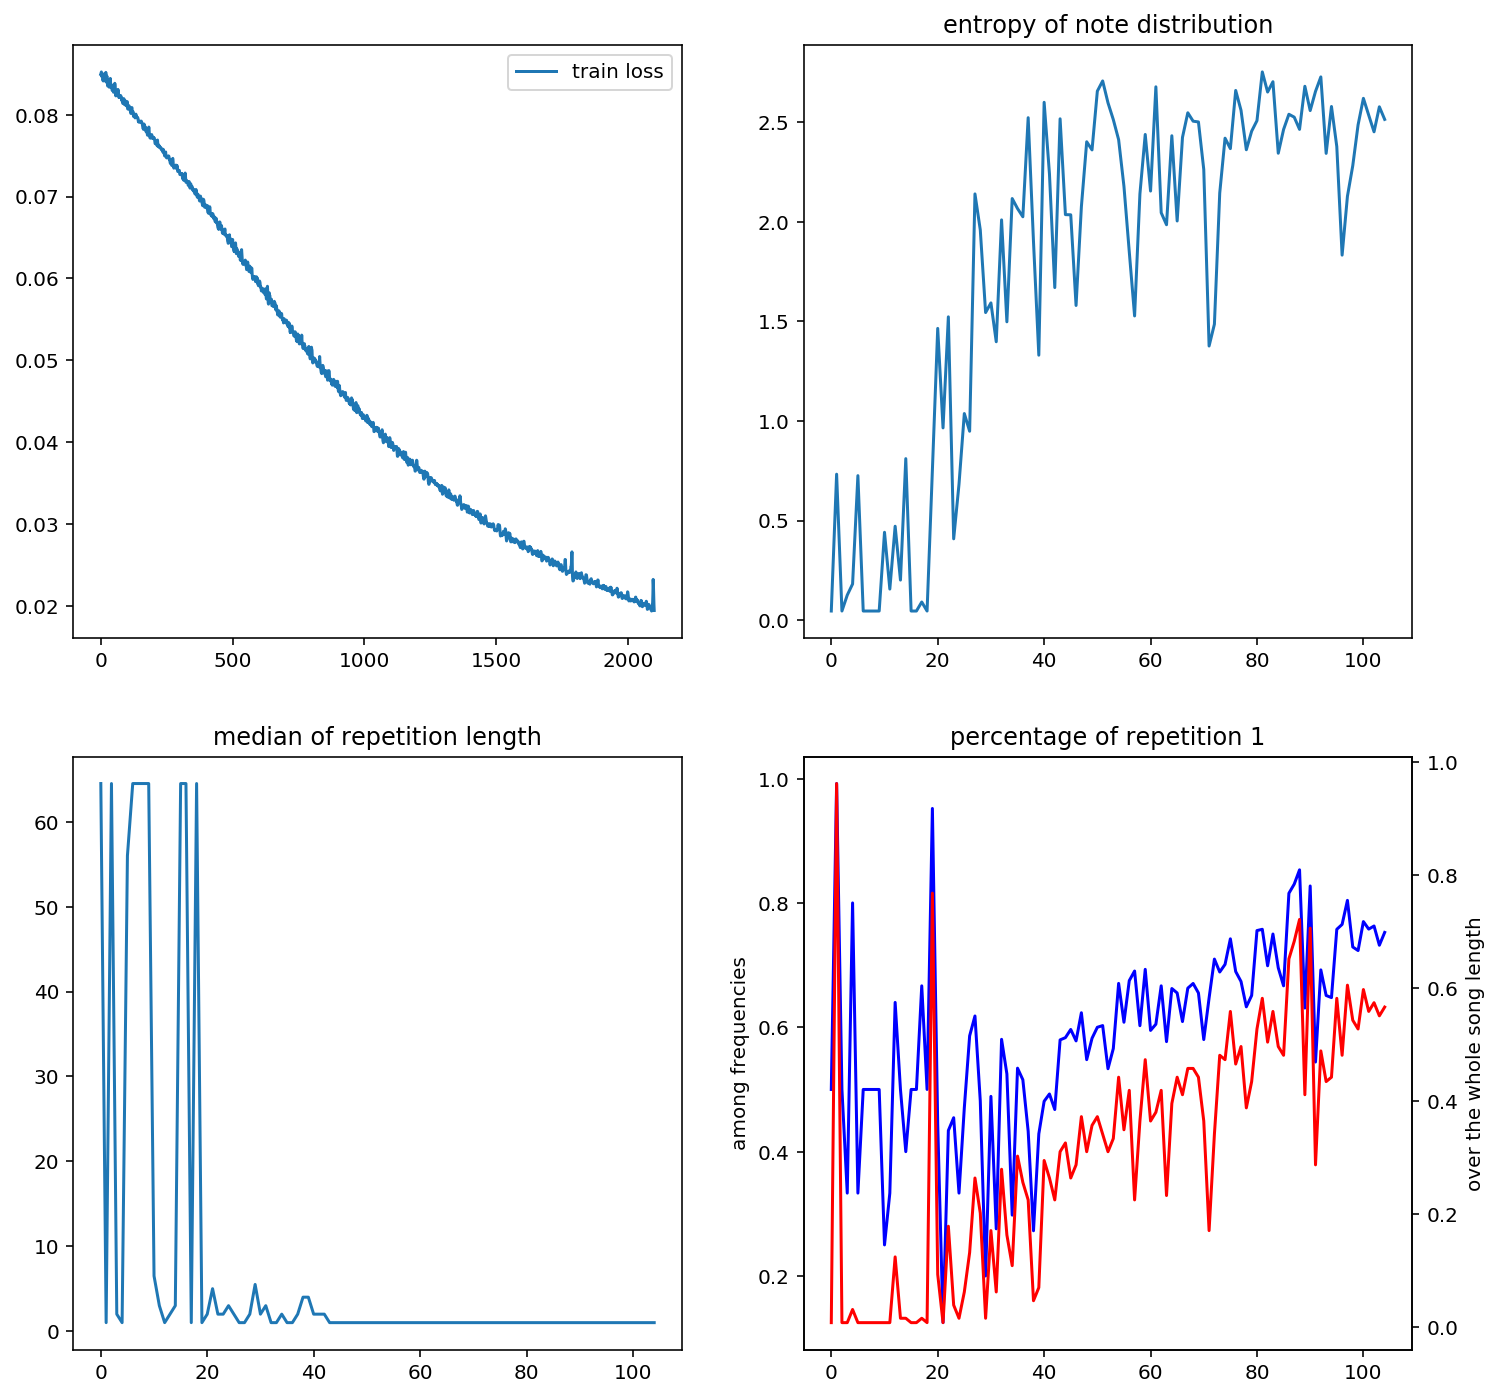

Epoch 2101/50000
676/676 [==============================] - 0s 407us/step - loss: 0.0191
Epoch 2102/50000
676/676 [==============================] - 0s 405us/step - loss: 0.0189
Epoch 2103/50000
676/676 [==============================] - 0s 405us/step - loss: 0.0189
Epoch 2104/50000
676/676 [==============================] - 0s 408us/step - loss: 0.0190
Epoch 2105/50000
676/676 [==============================] - 0s 405us/step - loss: 0.0190
Epoch 2106/50000
676/676 [==============================] - 0s 406us/step - loss: 0.0190
Epoch 2107/50000
676/676 [==============================] - 0s 407us/step - loss: 0.0192
Epoch 2108/50000
676/676 [==============================] - 0s 406us/step - loss: 0.0191
Epoch 2109/50000
676/676 [==============================] - 0s 405us/step - loss: 0.0189
Epoch 2110/50000
676/676 [==============================] - 0s 407us/step - loss: 0.0189
Epoch 2111/50000
676/676 [==============================] - 0s 407us/step - loss: 0.0190
Epoch 2112/50000
676/

KeyboardInterrupt: 

In [28]:
model.fit(nn_inout2[:-1,:lookback,:n_total], 
          nn_inout2[:-1,1:,:n_total], 
          epochs=50000, 
          batch_size=1024,
          callbacks=[basicLossPlot,reduce_lr])

### Generate a new song
(Create a "output" directory to get the output)

In [29]:
playDirectly = False
saveToOutput = True
showScore = True
colorize = False

526
entropy: 1.543 median repetition:1.000 percentage single notes0.694/0.388


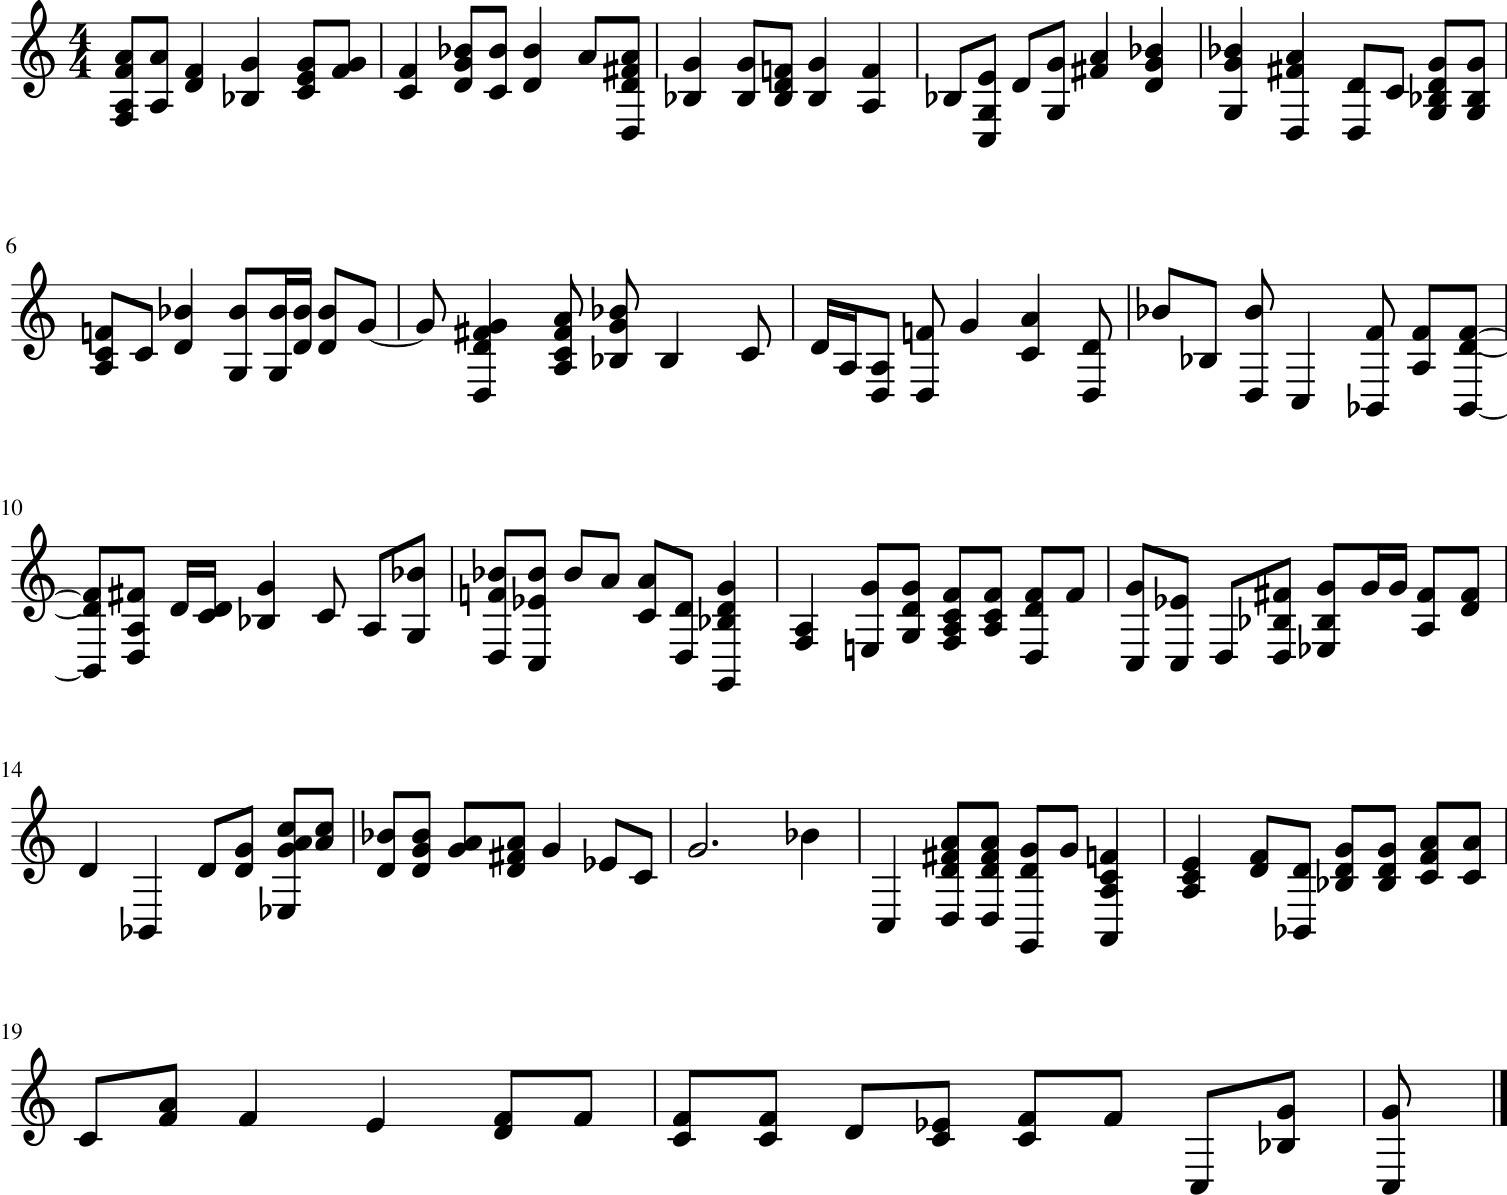

In [46]:
# t1 = instrument.ElectricOrgan()
# t1 = instrument.Organ()
t1 = instrument.Piano()
# t1 = instrument.Harpsichord()

i = random.randint(1,nn_inout2.shape[0]) # seed random sample from original input
print(i)
# l is the production length, 128 is ~30 seconds
# threshold dictates how many are single notes and how many are chords
s = predictOneStream(nn_inout2[i:i+1,:,:], threshold=0.85,cleanPred=False, l=128, colorize=colorize)

s.insert(0, t1)

# if you're generating on your workstation with a sound card:
if playDirectly == True:
    sp = midi.realtime.StreamPlayer(s)
    sp.play()
if saveToOutput == True:
    songname = f'output/test_outputpc5{datetime.now().strftime("%Y%m%d%H%M%S")}.mid'
    s.write('midi', fp=songname) # save the midi
    display(HTML(f'<A HREF="{songname}" target="_">the midi file</A>')) # make a link to the midi
if showScore == True:
    s.show() # show the score


### generation with evaluation information

In [54]:
i = random.randint(1,nn_inout2.shape[0])
i = 4
pp = predictOneBitstream(nn_inout2[i:i+1,:,:], cleanPred=False)
print(pp.shape)
v, e, m, p, p2 = subsongStats(pp[0]) 
print(e,m,p,p2, v)

(1, 129, 144)
0.8622796764324763 1.0 0.6041666666666666 0.2248062015503876 [ 53  58 129 129 129 129 129  63 131 129 129  63 129 129 129 129 129  63
 129  62  63  65 129 129 129 129 129 129  63 129 129  62 129 129  65 129
 129  63 129 129 129 129 129  65 129  63  62 129 129 129 129 129 129 129
  63 129 129 129 129  63 129 129 129 129 129  65 129 129 129 131  58 129
 129 129 129 129 129 129 129 129 129 129 135 129 129 129 129  60 129 129
 129 129 129 129 129 129 129 129 129  63 129 129 129 129  63 129 129 129
 129 129 129 129  65 129 129  63 129 129 129 129 129 129 129 129 129 129
 129 129 129]


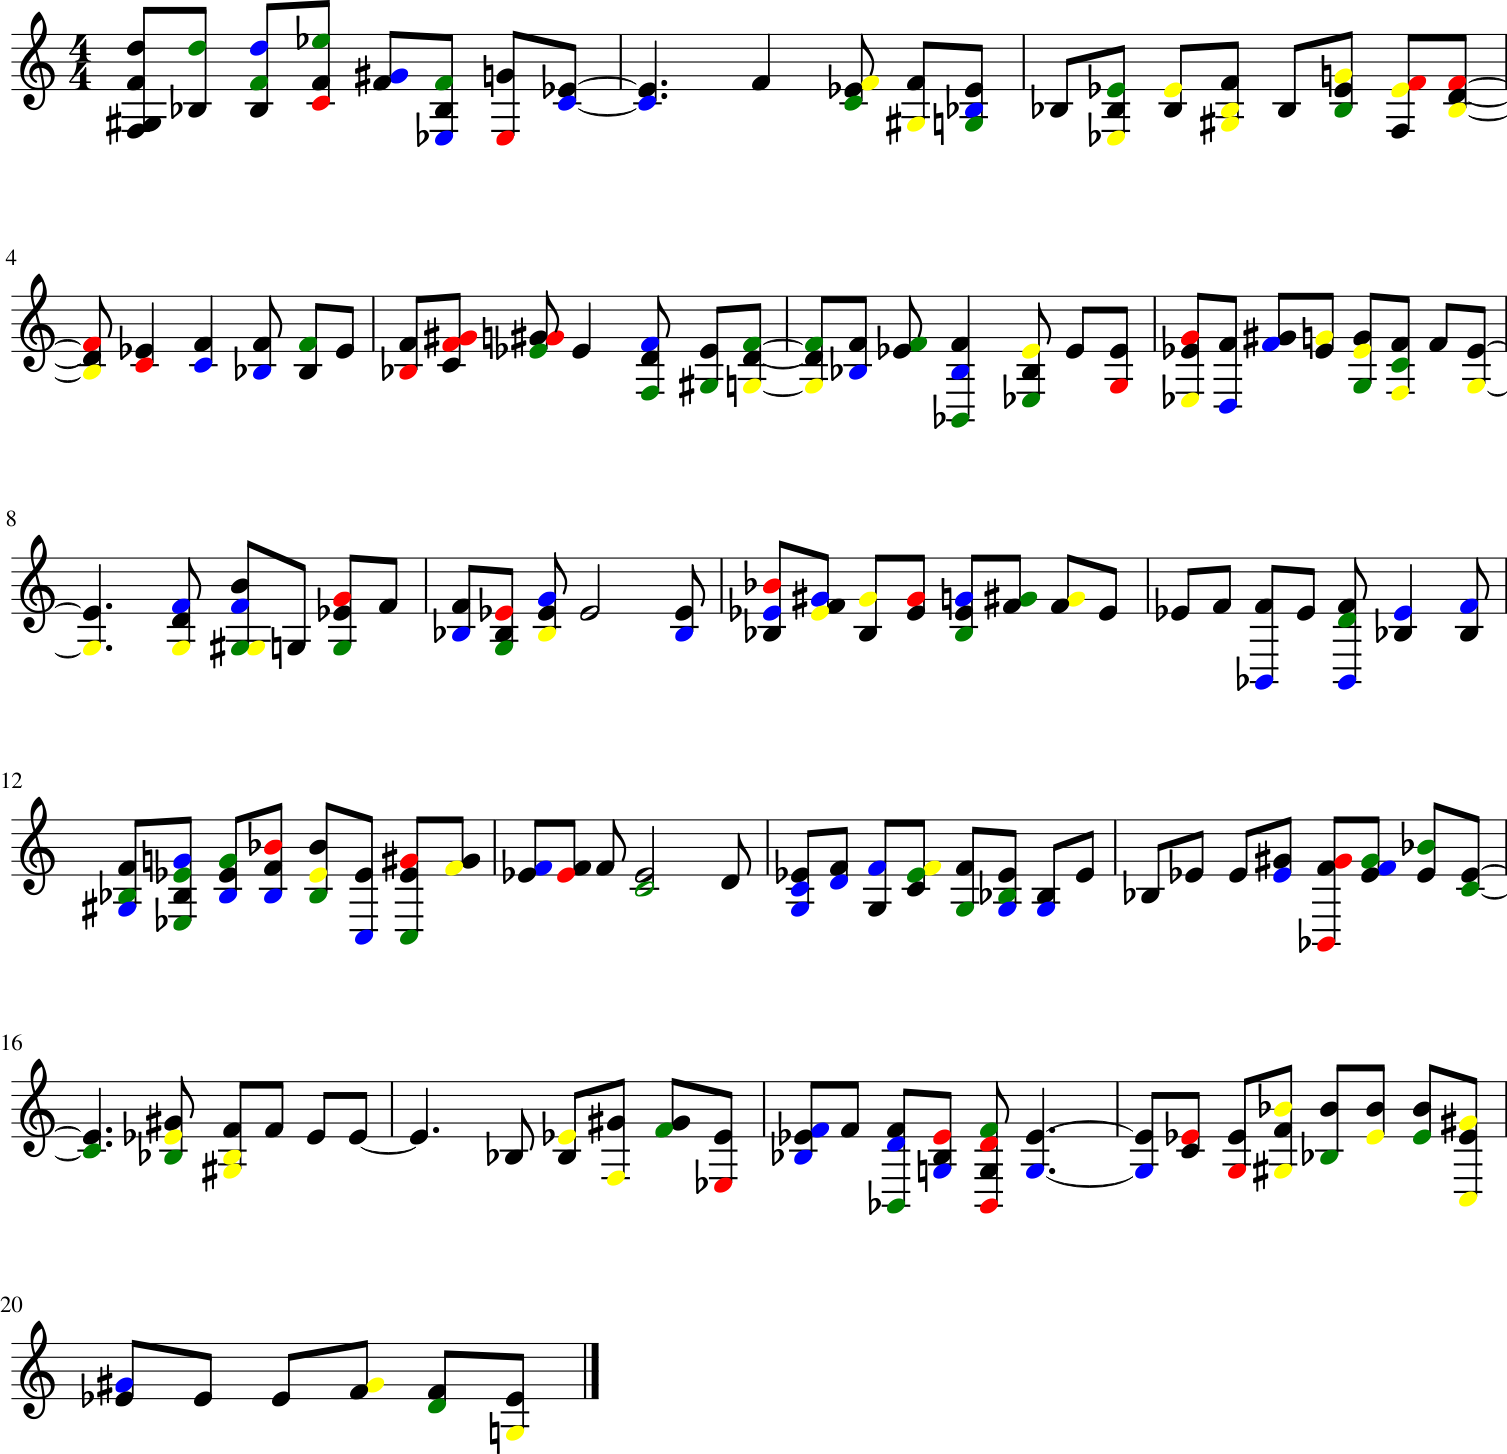

In [55]:
output_notes = []
s = stream.Stream()
for i in range(len(pp[0])):
    n = predbitfieldtonote(pp[0,i],threshold=0.8, colorize=True)
    s.append(n)
s.show()

In [56]:
songname = f'output/test_outputpc5{datetime.now().strftime("%Y%m%d%H%M%S")}.mid'
s.write('midi', fp=songname) # save the midi
display(HTML(f'<A HREF="{songname}" target="_">the midi file</A>')) # make a link to the midi


### Saving weights if happy

In [47]:
fname = f'weights-improvement-64-147-{datetime.now().strftime("%Y%m%d%H%M%S")}.hdf5'
print(fname)
model.save_weights(fname)


weights-improvement-64-147-20180312231552.hdf5


# Debugging function, see how much it's just slicing bits of the source

In [125]:
def notetolong(n):
    t = 0
    for i in range(n_vocab):
        if n[i] == 1:
            t = t+1<<i    
    return t
notetolong(nn_inout[0,:n_vocab])

55213970774324516429460210361771679588292845495907796731570758914932736

In [126]:
## construct an int view of the source
nn3 = []
for n in range(nn_inout.shape[0]):
    nn3.append(notetolong(nn_inout[n, :n_vocab]))
    
nn3 = np.stack(nn3)

In [127]:
nn3[:5]

array([55213970774324516429460210361771679588292845495907796731570758914932736,
       130370302485407138469202833387249861669062358861735351237542779832095851864308945701379768320,
       883423532389192360951077981205238572300032158692805118619612518083985408,
       32592575621351780998797919680681182671823717366875177546094443761665053684955351394228895744,
       883423532389192262871363365788346873412685527934524747705132142638923776],
      dtype=object)

In [128]:
notetolong(nn_inout[1])

130370302485407138469202833387249861669062358861735351237542779832095851864308945701379768320

In [129]:
np.where(nn3== notetolong(nn_inout[1]))

(array([    1,    50, 12447, 15401, 37237]),)

In [144]:
pp = predictOneBitstream(nn_inout2[i:i+1,:,:], cleanPred=True)[0]
ppp = [notetolong(x) for x in pp]
print(len(ppp))

129


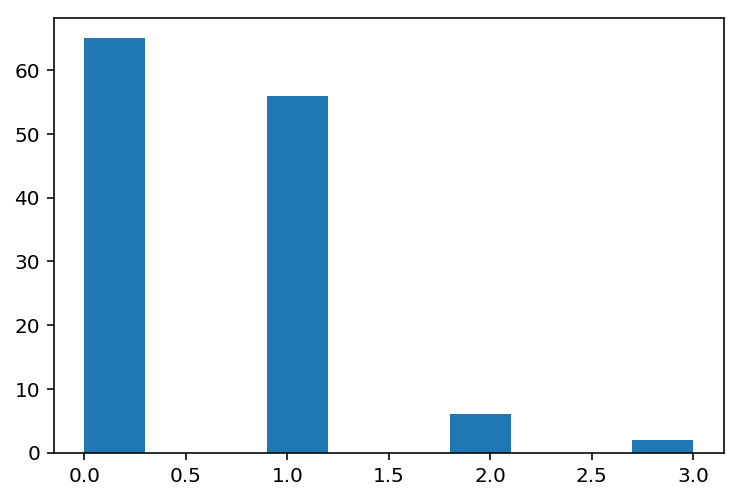

In [145]:
ll = []
longest = 0
for i in range(len(ppp)):
    longest = 0
    for x in np.where(nn3==ppp[i])[0]:
        for j in range(0,6):
            if nn3[x+j] != ppp[i]:
                break
        if j > longest:
            longest = j
    ll.append(longest)
plt.hist(ll);

In [ ]:
# Mostly not repeating things it found in the original data, yay!